In [1]:
# Main notebook for breakthrough infections
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns


import matplotlib.pyplot as plt
# %matplotlib widget
plt.rcParams['figure.figsize'] = (12,8)
# plt.rcParams["image.cmap"] = "Dark2"
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
    'axes.labelsize': fs_label,
    'axes.titlesize': fs_label+4,
    'xtick.labelsize': fs_label,
    'ytick.labelsize': fs_label, 
    'legend.fontsize': fs_label, 
    'lines.markersize': 10,
    'lines.linewidth': 3
}
plt.rcParams.update(parameters)
# %matplotlib widget  
# plt.style.use('ggplot')
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))
from matplotlib import cm # Colormaps

import locale
import matplotlib.dates as mdates
locale.setlocale(locale.LC_TIME,"Danish")
# ax = plt.gca()
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y \n %B'))

import os
# import csv
import math


from datetime import date


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

def rnMean(data,meanWidth):
    return np.convolve(data, np.ones(meanWidth)/meanWidth, mode='valid')
def rnTime(t,meanWidth):
    return t[math.floor(meanWidth/2):-math.ceil(meanWidth/2)+1]

R0 = 4.7

S = lambda V, Preval : (1-V)*(1-Preval)
Re = lambda R0, V, Preval: R0*S(V, Preval)
V = lambda Re, R0, Preval: 1 - (Re/R0)*(1/(1-Preval))
P = lambda Re, R0, Vacc: 1 - (Re/R0)*(1/(1-Vacc))

saveFigures is set to: True
Done loading packages


In [2]:
data_raw_df = pd.read_csv("owid-covid-data.csv")
# data_raw_df.columns

Denmark 0.7565000000000001 0.064025058
Estonia 0.5511 0.131631135
Latvia 0.5068 0.101086594
Lithuania 0.6118 0.138514541
Poland 0.5227 0.077917718
Spain 0.7934 0.106765311


,loc,vacc,preval
0,Denmark,0.7565,0.064025
1,Estonia,0.5511,0.131631
2,Latvia,0.5068,0.101087
3,Lithuania,0.6118,0.138515
4,Poland,0.5227,0.077918
5,Spain,0.7934,0.106765


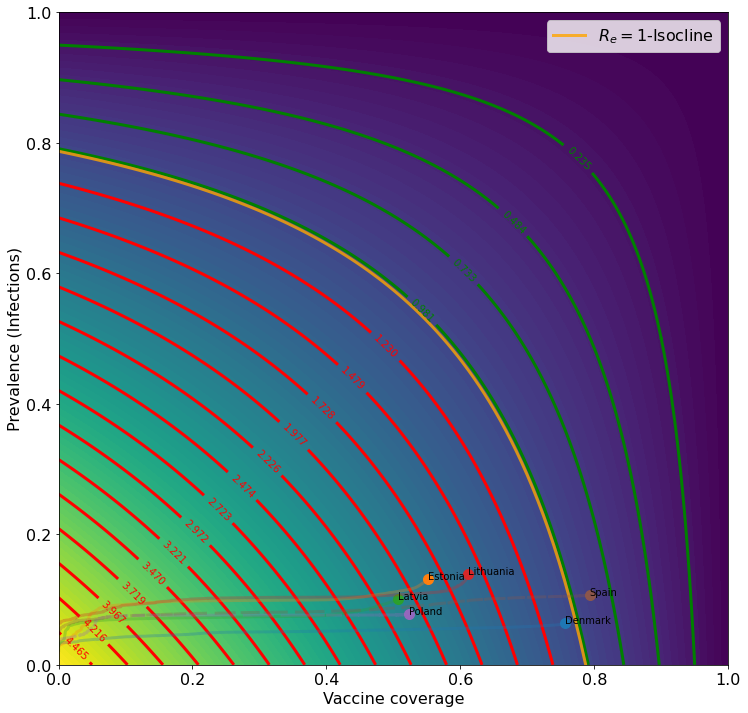

In [5]:
all_loc = data_raw_df.location.unique()

locs = ["Denmark", "Latvia", "Poland", "Estonia", "Lithuania", "Spain"]

loc_filt = data_raw_df.location.isin(locs)

data_df = data_raw_df.loc[loc_filt]

#fig1, ax1 = plt.subplots()
#fig2, ax2 = plt.subplots()
fig, ax = plt.subplots(figsize=(12,12))

scatterstyle = {
    # "color":'tab:red', 
    # "linestyle":':', 
    # "linewidth":5, 
    "marker":'o', 
    # "markersize":5, 
    # "edgecolors":'tab:red'
    # alpha":0.6
}

scatter_df = pd.DataFrame(columns=["loc", "vacc", "preval"])

resolution = 1001

xlab = "Vaccine coverage"
ylab = "Prevalence (Infections)"


# Adjust here, for the visible range in plot:
X = vacc_list = np.linspace(0, 1, resolution)
Y = preval_list = np.linspace(0, 1, resolution)
Z = np.array([[Re(R0, v, p) for v in vacc_list] for p in preval_list]) # Y=preval, X=vacc

#ax.pcolor(X, Y, Z)
ax.contourf(X, Y, Z, 100, cmap="viridis")

r0 = 4.7
res = np.linspace(0.05,0.95,18)*r0
for i, re in enumerate([1]):
    IsoVac = np.linspace(0,1-(re/r0),100)
    ax.plot(IsoVac, (lambda V: P(re, r0, V))(IsoVac), alpha=0.8, color="orange", label=int(i==0)*"$R_{e} = 1$-Isocline")

heard_immune_color = lambda r0: int(r0<1)*"green" + int(r0>=1)*"red"
hi_colors = [heard_immune_color(r) for r in res]

CS = ax.contour(X, Y, Z, levels=res, colors=hi_colors) # , cmap="plasma") #, label="$R_{0}$-isoclines")
clab_pos = [(1-np.sqrt(y),1-np.sqrt(y)) for y in res/r0]
#ax.scatter(*list(zip(*clab_pos)))
ax.clabel(CS, inline=True, fontsize=10, manual=clab_pos)

for loc, loc_data in data_df.groupby(["location"]):
    
    Prevals = loc_data.total_cases_per_million
    Preval = Prevals.dropna().values[-1]/int(1e6)

    Vaccs = loc_data.people_fully_vaccinated_per_hundred
    Vacc = Vaccs.dropna().values[-1]/100
    
    # Comment this line to not show history...
    ax.plot(Vaccs/100, Prevals/int(1e6), alpha=0.3)
    
    # present state in this parameter space:
    ax.scatter(Vacc, Preval, **scatterstyle)
    ax.annotate(loc, (Vacc, Preval))

    # Currently not used:
    row = {"loc":loc, "vacc":Vacc, "preval":Preval}
    scatter_df = scatter_df.append(row, ignore_index=True)
    print(loc, Vacc, Preval)
    
    #ax1.plot(loc_data.date, Prevals, label=loc)
    #ax2.plot(loc_data.date, Vaccs, label=loc)
    
ax.legend()
#ax2.legend()
#data_df

# ax.scatter(scatter_df.vacc, scatter_df.preval, **scatterstyle)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)

plt.savefig("figs/parameterspace_vacc_prevalence.png")
plt.savefig("figs/parameterspace_vacc_prevalence.pdf")
scatter_df